# Imports

In [139]:
import pandas as pd
import os
import seaborn as sns
import plotly.graph_objects as go
import matplotlib_inline

import torch

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator

import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
from numpy.testing import assert_almost_equal

from urllib.request import urlretrieve

from imblearn.over_sampling import SMOTE

from collections import Counter

from sklearn import svm
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import *

from IPython.core.display import display, HTML
from IPython.display import Image

from scipy.spatial.distance import pdist, cdist, squareform

pd.set_option('display.max_columns', None) # to display all columns

#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Global variables

In [334]:
NR_BINS = 5

font_labels = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 16}
current_path = os.getcwd()
image_path = os.path.join(current_path, "images")
tuning_path = os.path.join(current_path, "tuning")
datasets_path = os.path.join(current_path, "datasets")

# Preliminaries

We check folders hierarchy.

In [335]:
if not os.path.exists(tuning_path):
    os.makedirs(tuning_path)
if not os.path.exists(image_path):
    os.makedirs(image_path)
if not os.path.exists(os.path.join(datasets_path, "datasets-ml-25m")):
    os.makedirs(os.path.join(datasets_path, "datasets-ml-25m"))
if not os.path.exists(os.path.join(datasets_path, "datasets-ml-latest")):
    os.makedirs(os.path.join(datasets_path, "datasets-ml-latest"))

# Utility functions

Plot images horizontally aligned

In [141]:
def showImagesHorizontally(files):
	n_files = len(files)
	fig, ax = plt.subplots(nrows=1, ncols=n_files)
	fig.set_size_inches(8 *n_files, 10)
	for i in range(n_files):
		#fig.add_subplot(1, n_files, i+1)
		image = plt.imread(files[i])
        
		ax[i].imshow(image, cmap='gray', aspect='equal', resample=False)
		ax[i].axis('off')

def showTablesHorizontally(dfs:list, captions:list, tablespacing=5):
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

def name(dataset_name) :
    return "_".join(['df', dataset_name])

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [142]:
seed_everything(42)

# DATA ACQUISITION

We have uploaded the CSVs as a release of the Github repository so that it's possible to download them if they aren't locally available.

In [328]:
csv_names = ["movies.csv", "ratings.csv", "genome-scores.csv", "genome-tags.csv", "links.csv", "tags.csv"]
datasets_names = [i[:-4].replace("-", "_") for i in csv_names]

local_csv_dir = os.path.join(datasets_path, "datasets-ml-latest")
remote_csv_dir = "http://github.com/MickPerl/DataAnalyticsProject/releases/download/datasets_reduced/"

The following code tries to read the csv file given the local path: in case of failure, it download the file from the remote path to the local path so that it can successfully read them.

In [146]:
for i in range(len(csv_names)):
    local_csv_path = os.path.join(local_csv_dir, csv_names[i])
    
    '''
    nella versione da consegnare si utilizzerà la funzione name(), così da non occupare memoria con copie di DataFrame
    '''
    try : 
        # if the path exists as well as the file, read directly  
        globals()[datasets_names[i]] = pd.read_csv(local_csv_path)     
        # globals()[name(datasets_names[i])] = pd.read_csv(path)

    except FileNotFoundError:
        print(f"Download in progress of {csv_names[i]}")
        remote_csv_path = os.path.join(remote_csv_dir, csv_names[i])
        file, _ = urlretrieve(url = remote_csv_path, filename=local_csv_path)
        globals()[datasets_names[i]] = pd.read_csv(file)
        # globals()[name(datasets_names[i])] = pd.read_csv(file[0])

In [147]:
# prima della consegna, eliminare queste righe
df_movies = movies.copy()
df_ratings = ratings.copy()
df_links = links.copy()
df_genome_scores = genome_scores.copy()
df_genome_tags = genome_tags.copy()
df_tags = tags.copy()

# DATA PREPROCESSING

## Data manipulation

Within this section, we go through the `DataFrame`'s obtained by executing the previous data acquisition: we highlight their peculiarities and join them in order to end up getting the complete dataset.

### df_movies

In [148]:
output = df_movies.head().style.set_caption("df_movies")._repr_html_()
display(HTML(output))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The `df_movies` DataFrame contains the following information with regard to $62423$ films.

In [149]:
len(df_movies)

58098

Each film has a different title, therefore we have considered it as a negligible information: however, before dropping the corresponding column `title`, we have extracted from it the **year** of each film which could be a relevant feature.

In [150]:
title_trimmed = df_movies['title'].str.strip()
df_movies["year"] = title_trimmed.str.slice(start=-5, stop=-1)

df_movies["title_length"] = df_movies['title'].str.len()
df_movies.drop('title', inplace=True, axis=1)

In [151]:
# descrivere questa riga
df_movies.iloc[:,2] = pd.to_numeric(df_movies.iloc[:,2], errors='coerce')

For each film, the dataset `df_movies` stores its genres by a pipe-separated list:

In [152]:
df_movies.genres.head()

0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

Consequently, we have decided to add one column for each possible genre: if the film belongs to a certain genre, the corresponding cell will contain `1`, `0` otherwise.
To do that, first of all we instantiate the class `MultiLabelBinarizer` from the `preprocessing` module of the `sklearn` library: its method `fit_transform` takes as input the set of labels for each samples and outputs a matrix of shape (# samples, # unique labels) such that each cell has `1` if the corresponding film belongs to the corresponding genre, `0` otherwise.\
Then, we convert this matrix to a `DataFrame` object whose columns are the genres' name; eventually, the result is joined with `df_movies` DataFrame.

In [153]:
mlb = MultiLabelBinarizer()
df_movies = df_movies.join(pd.DataFrame(
                mlb.fit_transform(df_movies.pop('genres').str.split('|')),
                index=df_movies.index,
                columns=mlb.classes_))
        
df_movies.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995.0,16,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,1995.0,14,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,1995.0,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1995.0,24,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,1995.0,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### df_genome_tags and df_genome_scores

`df_genome_scores` contains tag relevance scores for movies.\
The set of relevances regarding a film is its *genome*: thus, the genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.).  

In [154]:
output = df_genome_scores.head().style.set_caption('df_genome_scores')._repr_html_()
display(HTML(output))

,movieId,tagId,relevance
0,1,1,0.029000
1,1,2,0.023750
2,1,3,0.054250
3,1,4,0.068750
4,1,5,0.160000


ci sono 15584448 rating degli utenti

In [155]:
len(df_genome_scores)

14862528

In particular, only $13816$ films out of $62423$ have a genome: the remaining 48607 aren't characterized by any tag.

In [156]:
len(df_genome_scores.groupby("movieId"))

13176

The structure of `df_genome_scores` is a dense matrix: each movie within it has a value for every tag in the genome as it's possible to prove through grouping by `movieId` value and seeing that the number of unique tags is the same over all films.

In [157]:
print(*df_genome_scores.groupby("movieId").count().tagId.unique())

1128


to add

In [158]:
len(df_genome_tags)

1128

We can continue merging `df_genome_scores` with `df_genome_tags` which explicits every tag.

In [159]:
showTablesHorizontally([df_genome_scores.head(), df_genome_tags.head()], ['df_genome_scores', 'df_genome_tags'])

In [160]:
df_genome = pd.merge(df_genome_scores, df_genome_tags, on="tagId", how="left")

After that, we want to manipulate the `df_genome` DataFrame in order to relate every film to its genome. 

In [161]:
df_genome = df_genome.pivot(index='movieId', columns='tag', values="relevance")
df_genome.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble cast,entertaining,entirely dialogue,environment,environmental,epic,erotic,espionage,ethnic conflict,evolution,excellent,excellent script,exceptional acting,exciting,

We can merge the result with `df_movies`.

In [162]:
df = pd.merge(df_movies, df_genome, on="movieId", how = "left")
df.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously l

### df_rating

Each row of `df_ratings` DataFrame represents one rating of one movie by one user, and has the following format:

In [163]:
output = df_ratings.head().style.set_caption("table df_ratings")._repr_html_()
display(HTML(output))

,userId,movieId,rating,timestamp
0,1,307,3.500000,1256677221
1,1,481,3.500000,1256677456
2,1,1091,1.500000,1256677471
3,1,1257,4.500000,1256677460
4,1,1449,4.500000,1256677264


In [164]:
len(df_ratings)

27753444

*Ratings* are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).\
*Timestamps* represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

We select only the `movieId` and `rating` columns and we average ratings relating each film and then we join the result with the complete DataFrame.

In [165]:
df_ratings = df_ratings.iloc[:,[1,2]]

df_ratings = df_ratings.groupby(by='movieId').rating.agg(rating_mean= 'mean', ratings_count= 'count')
df_ratings.head()

,rating_mean,ratings_count
movieId,,
1,3.886649,68469
2,3.246583,27143
3,3.173981,15585
4,2.874540,2989
5,3.077291,15474


Ratings are indicated for $59047$ out of $62423$.

In [166]:
len(df_ratings)

53889

In [167]:
df = pd.merge(df, df_ratings, on="movieId", how="left")

### Result: Merged Dataframe

In [168]:
df.head()

,movieId,year,title_length,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously l

## Data cleaning

### Checking missing data

#### Films without rating

There are $3376$ films without a rating.

In [169]:
sum(df.rating_mean.isna())

4209

Since the rating is the label and the cardinality of the complete dataset is big, we can drop these films.

In [170]:
df.dropna(subset=['rating_mean'], inplace=True)

The new cardinality is $59047$.

In [171]:
len(df)

53889

In [172]:
df.ratings_count = df.ratings_count.astype('int') 

#### Films without tags and/or genres
There are $40713$ films without a relevance for any tag.

In [173]:
sum((df.iloc[:, 23:-2]).isna().all(axis = 1))

40713

We save these films in a temporary DataFrame.

In [174]:
df_without_tags = df[df.iloc[:, 23:-2].isna().all(axis = 1)]

Given this subset, we want to look for those films without any genres.

In [175]:
df_without_tags_nor_genres = df_without_tags[df_without_tags['(no genres listed)'] == 1]

In [176]:
len(df_without_tags_nor_genres)

3703

We drop these samples.

In [177]:
rows_to_be_deleted = df.loc[df["movieId"].isin(df_without_tags_nor_genres["movieId"])].index

In [178]:
df.drop(rows_to_be_deleted, axis=0, inplace=True)

In [179]:
len(df)

50186

Regarding remaining films without tags, we set to `0` their relevance under the different tags.

In [180]:
df.iloc[:, 23:-2] = df.iloc[:, 23:-2].fillna(0)

After the dropping, there are still $29$ films which don't belong to any genres.

In [181]:
sum(df['(no genres listed)'] == 1)

29

We can prove that these films are those which have `0` under the columns of the genres.

In [182]:
sum((df.iloc[:, 4:23] == 0).all(axis = 1)) == sum(df['(no genres listed)'] == 1)

True

Since the absence of genres is somehow expressed by the genres columns, it's possible to drop the `(no genres listed)`.

In [183]:
df.drop(['(no genres listed)'], inplace=True, axis=1)

#### Films without years
There are $370$ films without an year.

In [184]:
sum(df.year.isna())

103

To decide the value to substitute to `na`, we plot the distribution of the values.

In [185]:
df_year_without_na = df.year[-pd.isna(df.year)]

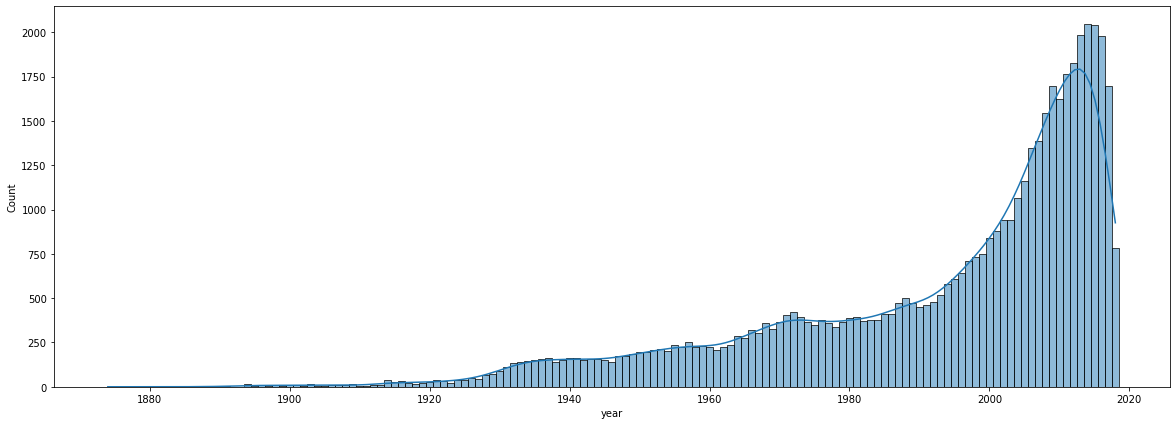

In [186]:
plt.figure(figsize=(20,7))
sns.histplot(df_year_without_na, kde=True, discrete=True)
plt.show()

Since it's not simmetric, we decide to fill `na` values with the *median*.

In [187]:
df.year = df.loc[:, 'year'].fillna(np.median(df_year_without_na)).astype('int')

We can check the absence of `Null` or `Na` values.

In [188]:
sum(pd.isna(df).any(axis=1))

0

After checking missing data and before checking duplicates, we drop the `movieId` column since contains unique values which are useful only to indexing purposes.

In [189]:
df.drop('movieId', inplace=True, axis=1)

### Checking duplicates 

There are $393$ duplicated rows.

In [190]:
sum(df.duplicated())

393

We have deleted them by keeping the first.

In [191]:
df.drop_duplicates(inplace=True)

So that, there aren't any duplicated row.

In [192]:
sum(df.duplicated())

0

In [193]:
len(df)

49793

## Data Trasformation

### Continuous label discretization

Binning by equal width boundaries (width: 0.9)

In [194]:
df['bin_y'] = pd.cut(df['rating_mean'], bins=NR_BINS, labels=False)

### Train/Test/Validation set splitting

In [302]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=13, stratify=df['bin_y'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=13, stratify=df_train['bin_y'])

In [303]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

### Balancing Training Set

#### Evaluating

We evaluate to which extent bins are balanced.

In [196]:
df_train.bin_y.value_counts()

3    15797
2    14236
1     3672
4     1186
0      959
Name: bin_y, dtype: int64

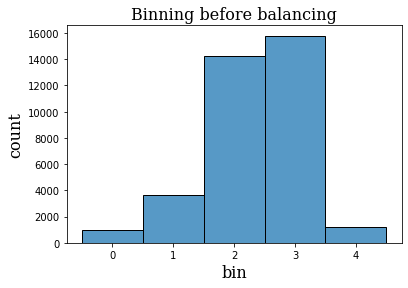

In [197]:
sns.histplot(df_train.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning before balancing", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "initial_binning.png"), facecolor='white', transparent=False)
plt.show()

In [198]:
len(df_train)

35850

#### SMOTE balancing 

Synthetic Minority Over-sampling

function to dataset balancing with lower bound

In [728]:
def balancing(df_train, lower_bound, remove_duplicates=True):

	bins_count = df_train.bin_y.value_counts()
	for i in range(len(bins_count)):
		if bins_count[i] <= lower_bound:
			bins_count[i] = lower_bound

	bin_sizes = bins_count.to_dict()

	sm = SMOTE(random_state=43, sampling_strategy=bin_sizes)
	df_train_balanced, _ = sm.fit_resample(df_train, df_train['bin_y'])

	#rimuove i duplicati
	if remove_duplicates:
		df_train_balanced.drop_duplicates(inplace=True)

	return df_train_balanced.reset_index(drop=True)

Example of use

In [391]:
df_train_SMOTE = balancing(df_train, 5000, remove_duplicates=False)

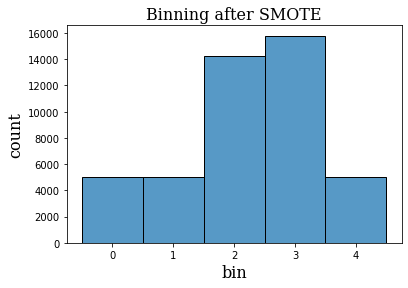

In [385]:
sns.histplot(df_train_SMOTE.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning after SMOTE", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "after_SMOTE_binning.png"),facecolor='white', transparent=False)
plt.show()

##### Checking new duplicates

In [386]:
df_train_SMOTE.duplicated().sum()

1354

In [387]:
df_train_SMOTE.drop_duplicates(inplace=True)

In [388]:
df_train_SMOTE.duplicated().sum()

0

Dopo eliminazione duplicati dal dataset di train, occorre ricavare y_train (la y_train in output da SMOTE contiene i duplicati che si sono prodotti).

In [372]:
y_train_categorical_SMOTE = df_train['bin_y']

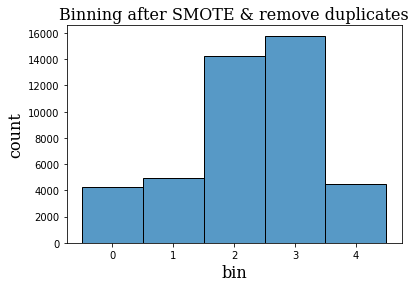

In [373]:
sns.histplot(df_train_SMOTE.bin_y, discrete=True)
plt.xlabel('bin', fontdict=font_labels)
plt.ylabel('count', fontdict=font_labels)
plt.title("Binning after SMOTE & remove duplicates", fontdict=font_labels)
plt.savefig(os.path.join(image_path, "after_SMOTE_and_removed_duplicates_binning.png"),facecolor='white', transparent=False)
plt.show()

##### SMOTE Balancing result

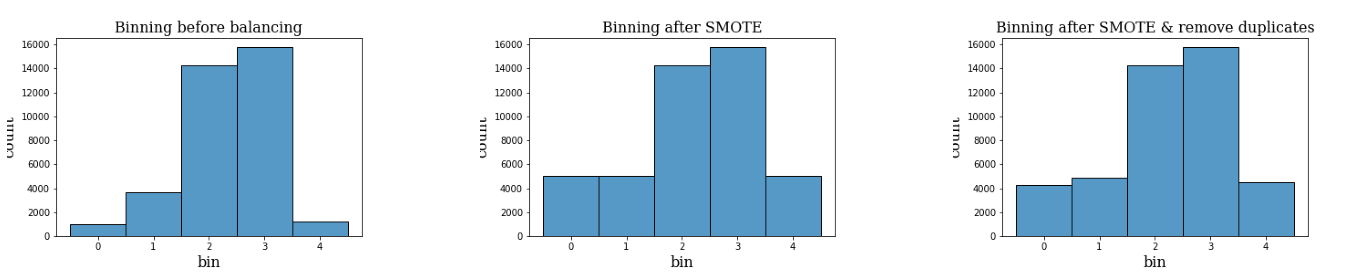

In [389]:
images = [os.path.join(image_path, "initial_binning.png"), os.path.join(image_path, "after_SMOTE_binning.png"), os.path.join(image_path, "after_SMOTE_and_removed_duplicates_binning.png")]
showImagesHorizontally(images)

#### Sub sets slicing

In [524]:
def generateSets(data, n_samples, size):
	samples = []
	data = shuffle(data, random_state=43).reset_index(drop=True)
	for s in range(n_samples):
		if(len(data) >= n_samples * size):
			start = s * size
			end = start + size
			samples.append(data.iloc[start:end])
		else:
			samples.append(data.sample(size, replace=False, ignore_index=True, random_state=43))

	return samples

In [638]:
def RandomSubSets(df, size, n_samples): 
	df_samples = [pd.DataFrame(columns=df.columns) for _ in range(n_samples)]
	for c in df.bin_y.unique():       
		df_class_c = df[df.bin_y == c]
		df_class_sets = generateSets(df_class_c, n_samples, size)
		
		for i in range(n_samples):
			df_samples[i] = df_samples[i].append(df_class_sets[i], ignore_index=True)
	
	return df_samples

Example of use

In [639]:
min_bin_cardinality = df_train.bin_y.value_counts().min()
samples = RandomSubSets(df_train_SMOTE, 2000, 7)

resulting splitting

In [366]:
[len(x) for x in samples]

[10000, 10000, 10000, 10000, 10000, 10000, 10000]

SCRIVERE CHE SI STA PROCEDENDO SUI DATI BILANCIATI CON SMOTE

### Extracting X and y from Training/Validation/Test Set

In [400]:
def split_XYweights(df):
	y_categorical = df['bin_y'].astype('int')
	y_train_continuous = df['rating_mean'].astype('int')
	weights = df['ratings_count']
	X = df.drop(columns=['bin_y', 'rating_mean', 'ratings_count'], axis=1)
	
	return X, y_categorical, weights

Example of use

In [402]:
y_train_continuous = df_train['rating_mean']	
X_train, y_train_categorical, train_ratings_count = split_XYweights(df_train)

y_val_continuous = df_val['rating_mean']
X_val, y_val_categorical, val_ratings_count = split_XYweights(df_val)

y_test_categorical = df_test['bin_y']
X_test, y_test_categorical, test_ratings_count = split_XYweights(df_test)

### Evaluating Standardization or Min-Max Scaling

In [403]:
pd.set_option('display.max_rows', df.shape[0]+1)
X_train.describe().loc[['mean', 'min', 'max']]

,year,title_length,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,3d,70mm,80s,9/11,aardman,aardman studios,abortion,absurd,action,action packed,adaptation,adapted from:book,adapted from:comic,adapted from:game,addiction,adolescence,adoption,adultery,adventure,affectionate,afi 100,afi 100 (laughs),afi 100 (movie quotes),africa,afterlife,aging,aids,airplane,airport,alaska,alcatraz,alcoholism,alien,alien invasion,aliens,allegory,almodovar,alone in the world,alter ego,alternate endings,alternate history,alternate reality,alternate universe,amazing cinematography,amazing photography,american civil war,amnesia,amy smart,android(s)/cyborg(s),androids,animal movie,animals,animated,animation,anime,antarctica,anti-hero,anti-semitism,anti-war,apocalypse,archaeology,argentina,arms dealer,arnold,art,art house,artificial intelligence,artist,artistic,artsy,assassin,assassination,assassins,astronauts,atheism,atmospheric,australia,australian,author:alan moore,author:neil gaiman,autism,aviation,awesome,awesome soundtrack,awful,bad,bad acting,bad cgi,bad ending,bad plot,bad science,bad script,bad sequel,ballet,bank robbery,baseball,based on a book,based on a comic,based on a play,based on a true story,based on a tv show,based on a video game,based on book,based on comic,based on true story,basketball,batman,bdsm,beatles,beautiful,beautiful scenery,beautifully filmed,beauty pageant,beer,berlin,best of 2005,best war films,betrayal,better than expected,better than the american version,biblical,big budget,biographical,biography,biopic,birds,biting,bittersweet,bizarre,black and white,black comedy,blaxploitation,bleak,blindness,blood,bloody,boarding school,boat,bollywood,bombs,bond,book,book was better,books,boring,boring!,boston,bowling,boxing,brainwashing,brazil,breathtaking,brilliant,british,british comedy,broadway,brothers,brutal,brutality,buddy movie,bullshit history,bullying,business,c.s. lewis,california,camp,campy,canada,cancer,cannibalism,caper,capitalism,car chase,carrie-anne moss,cars,cartoon,casino,catastrophe,cathartic,catholicism,censorship,cerebral,cgi,character study,chase,cheating,cheerleading,cheesy,chess,chicago,chick flick,child abuse,childhood,children,china,chocolate,chris tucker,christian,christianity,christmas,cia,cinematography,circus,civil war,classic,classic car,classical music,claustrophobic,claymation,clever,clones,cloning,clowns,coen bros,coen brothers,cold war,college,colonialism,colourful,comedy,comic,comic book,comic book adaption,comics,coming of age,coming-of-age,communism,compassionate,competition,complex,complex characters,complicated,complicated plot,computer animation,computer game,computers,con artists,con men,confrontational,confusing,conspiracy,conspiracy theory,controversial,cooking,cool,corny,corporate america,corruption,costume drama,courage,court,courtroom,courtroom drama,crappy sequel,crazy,creativity,creepy,crime,crime gone awry,criterion,cross dressing,crude humor,cuba,cult,cult classic,cult film,culture clash,cute,cute!,cyberpunk,cyborgs,cynical,dance,dancing,dark,dark comedy,dark fantasy,dark hero,dark humor,dc comics,deadpan,death,death penalty,demons,depp & burton,depressing,depression,desert,destiny,detective,devil,dialogue,dialogue driven,dinosaurs,directorial debut,disability,disappointing,disaster,disney,disney animated feature,distopia,disturbing,divorce,doctors,documentary,dog,dogs,dolphins,downbeat,dr. seuss,dragon,dragons,drama,dramatic,dreamlike,dreams,dreamworks,drinking,drug abuse,drug addiction,drugs,dumb,dumb but funny,dynamic cgi action,dysfunctional family,dystopia,dystopic future,earnest,easily confused with other movie(s) (title),east germany,eccentricity,ecology,educational,eerie,effects,egypt,emma watson,emotional,end of the world,england,enigmatic,ennio morricone,enormously long battle scene,ensemble c

The genres columns have `0` or `1` as values.\
We have evaluating the feasibility of the standardization over relevance tags by plotting the distribution.

Since the number of tags is too high, we have plotted the distribution of only 12 randomly sampled tags. 

In [218]:
# len(X_train.iloc[:,22:].columns)

In [219]:
# columns_sampled = np.random.choice(df.iloc[:,21:-2].columns, 12, replace=False)
# 
# fig = plt.figure(figsize = (20,10))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# for i in np.arange(1,13):
#     ax = fig.add_subplot(3, 4, i)
#     X_train[columns_sampled[i-1]].plot(kind ='density')
# plt.show()

Since it turns out that distributions aren't gaussian, we have excluded the standardization: the min-max scaling is pointless as values are already scaled between 0 and 1.  

#### MinMaxScaling function

In [220]:
def MinMaxScaling(X_train, X_val, X_test, cols):
	X_train_minmaxscaled = X_train.copy()
	X_val_minmaxscaled = X_val.copy()
	X_test_minmaxscaled = X_test.copy()
	
	for col in cols:
		min = np.min(X_train[col])
		max = np.max(X_train[col])
		range = max - min

		X_train_minmaxscaled[col] = (X_train[col] - min) / range
		X_val_minmaxscaled[col] = (X_val[col] - min) / range
		X_test_minmaxscaled[col] = (X_test[col] - min) / range

	return X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled

#### feature: title_len

Regarding the `title_legth` feature, we plot its distribution to evaluate the feasibility of the standardization.

In [221]:
pd.cut(df['title_length'], bins=len(X_train['title_length'].unique()), labels=False)

0          8
1          6
2         12
3         13
4         19
5          5
6          6
7         10
8         10
9          8
10        17
11        19
12         5
13         5
14        12
15         6
16        15
17         8
18        21
19         9
20         8
21         6
22         8
23         6
24        13
25         6
26        10
27         8
28        37
29        31
30        12
31        24
32        12
33         5
34         8
35        12
36        16
37        10
38         7
39        17
40         9
41        12
42         9
43        10
44         8
45        20
46        15
47         8
48        15
49        14
50        11
51        12
52         7
53        11
54         6
55        17
56        15
57        18
58        25
59        19
60        11
61        13
62        48
63        10
64         7
65        24
66         7
67        19
68         6
69        14
70         8
71        15
72        12
73        10
74         8
75         8
76         8

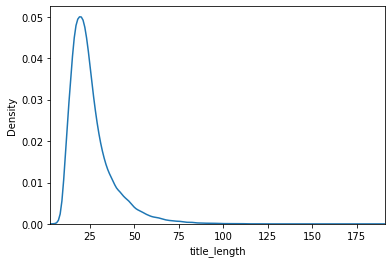

In [222]:
sns.kdeplot(X_train['title_length'])
plt.xlim([X_train['title_length'].min(), X_train['title_length'].max()])
plt.savefig(os.path.join(image_path, "initial_title_lenght.png"),facecolor='white', transparent=False)
plt.show()

Such distribution is not gaussian therefore we end up to apply *min-max scaling* in order to scale values in the range [0,1].

In [415]:
X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled = MinMaxScaling(X_train, X_val, X_test, ['title_length'])

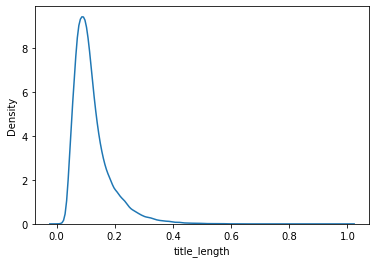

In [224]:
sns.kdeplot(X_train_minmaxscaled['title_length'])
plt.savefig(os.path.join(image_path, "after_minmaxscaled_title_lenght.png"), facecolor='white', transparent=False)
#plt.close()

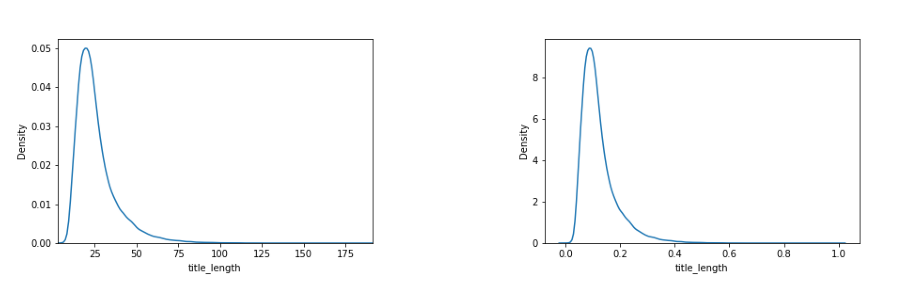

In [225]:
images = [os.path.join(image_path, "initial_title_lenght.png"), os.path.join(image_path, "after_minmaxscaled_title_lenght.png")]
showImagesHorizontally(images)

#### feature: year

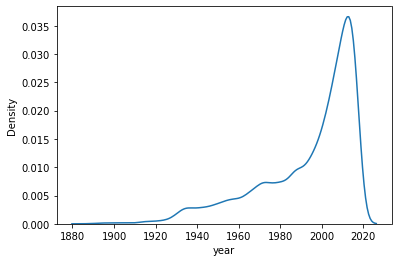

In [226]:
sns.kdeplot(X_train['year'])
plt.savefig(os.path.join(image_path, "initial_year.png"), facecolor='white', transparent=False)
plt.show()

In [418]:
X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled = MinMaxScaling(X_train, X_val, X_test, ['year'])

In [228]:
sns.kdeplot(X_train_minmaxscaled['year'])
plt.savefig(os.path.join(image_path, "after_minmaxscaled_year.png"), facecolor='white', transparent=False)
plt.close()

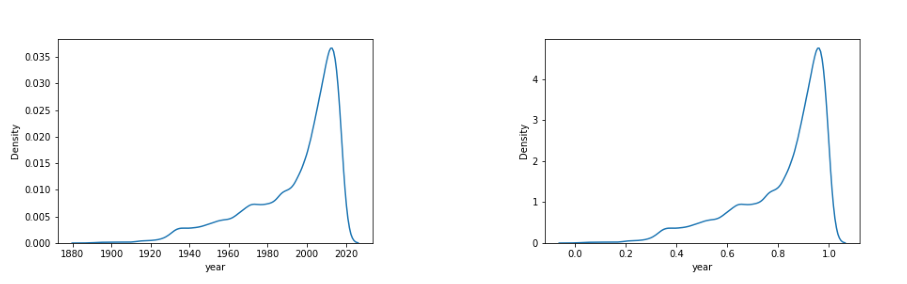

In [229]:
images = [os.path.join(image_path, "initial_year.png"), os.path.join(image_path, "after_minmaxscaled_year.png")]
showImagesHorizontally(images)

#### feature: ratings_count

In [230]:
train_ratings_count.loc[train_ratings_count> 80000]

8800     92406
12651    87899
12926    84545
13350    97999
34349    81815
41252    88224
41429    87416
41844    83377
42287    86048
42333    93732
43004    93394
43256    95979
43451    83539
43578    83500
44002    94574
44463    82170
44854    82759
Name: ratings_count, dtype: int32

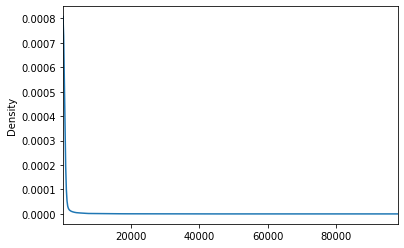

In [231]:
train_ratings_count.plot(kind='density', xlim=(train_ratings_count.min(), train_ratings_count.max()))
plt.savefig(os.path.join(image_path, "initial_ratings_count.png"), facecolor='white', transparent=False)
plt.show()

In [232]:
train_ratings_count_minmaxscaled, val_ratings_count_minmaxscaled, test_ratings_count_minmaxscaled = \
    MinMaxScaling(train_ratings_count.to_frame(), val_ratings_count.to_frame(), test_ratings_count.to_frame(), ['ratings_count'])

In [233]:
train_ratings_count_minmaxscaled = train_ratings_count_minmaxscaled.iloc[:,0]
train_ratings_count_minmaxscaled.plot(kind='density', xlim=(train_ratings_count_minmaxscaled.min(), train_ratings_count_minmaxscaled.max()))
plt.savefig(os.path.join(image_path, "after_minmaxscaled_ratings_count.png"), facecolor='white', transparent=False)
plt.close()

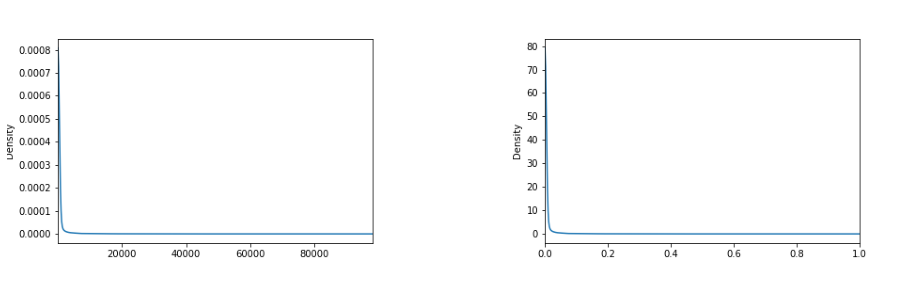

In [234]:
images = [os.path.join(image_path, "initial_ratings_count.png"), os.path.join(image_path, "after_minmaxscaled_ratings_count.png")]
showImagesHorizontally(images)

### Evaluating normalization

In [235]:
def normalization(X_train, ord):
	X_train_normalized = X_train.copy()
	X_train_normalized.iloc[:,:] = normalize(X_train, norm=ord)

	# alternative code in slides
	# x_norm2 = np.linalg.norm(x, ord=2)
	# x_normalized = x / x_norm2
	
	return X_train_normalized

L2 normalization is applied to each observation so the that the values in a row have a unit norm. Unit norm with L2 means that if each element were squared and summed, the total would equal 1

In [236]:
X_train_normalized_l2 = normalization(X_train, 'l2')

In [237]:
X_train_normalized_l1 = normalization(X_train, 'l1')

In [238]:
X_train_normalized_lmax = normalization(X_train, 'max')

In [239]:
X_train_normalized_SSRN = X_train.copy()
X_train_normalized_SSRN.iloc[:,:] = np.sign(X_train)*np.sqrt(np.abs(X_train))

In [240]:
X_train_minmaxscaled_normalized_SSRN = X_train_minmaxscaled.copy()
X_train_minmaxscaled_normalized_SSRN.iloc[:,:] = np.sign(X_train_minmaxscaled)*np.sqrt(np.abs(X_train_minmaxscaled))

In [241]:
showTablesHorizontally(
    [
        X_train_normalized_l2.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_l1.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_lmax.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']],
        X_train_minmaxscaled_normalized_SSRN.iloc[:,:4].describe().loc[['mean', 'min', 'max']]
    ],
    [
        "X_train_normalized_l2",
        "X_train_normalized_l1",
        "X_train_normalized_lmax",
        "X_train_minmaxscaled",
        "X_train_normalized_SSRN",
        "X_train_minmaxscaled_normalized_SSRN"
    ])

,year,title_length,Action,Adventure
mean,0.999894,0.013040,0.000056,0.000031
min,0.995475,0.001498,0.000000,0.000000
max,0.999999,0.095020,0.000527,0.000526
,year,title_length,Action,Adventure
mean,0.973019,0.012651,0.000054,0.000030
min,0.845371,0.001495,0.000000,0.000000
max,0.997509,0.087016,0.000522,0.000517
,year,title_length,Action,Adventure
mean,1.000000,0.013042,0.000056,0.000031
min,1.000000,0.001499,0.000000,0.000000


### Dimensionality reduction

In [242]:
len(X_train_minmaxscaled.columns)

1149

LDA function

In [434]:
def LDA(X_train, X_val, X_test, y, debug=False):
	lda = LinearDiscriminantAnalysis(solver = "eigen")
	lda.fit(X_train, y)

	s = 0
	nr_canonical_variables = 1
	for comp in lda.explained_variance_ratio_:
		s += comp
		if s < 0.95:
			nr_canonical_variables += 1
		
	if debug:
		print(lda.explained_variance_ratio_)
		print(f"get first {nr_canonical_variables} eigenvalues")

	X_train = lda.transform(X_train)
	X_train = X_train[:,:nr_canonical_variables]
	X_train = pd.DataFrame(X_train, columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])

	X_val = pd.DataFrame(lda.transform(X_val)[:,:nr_canonical_variables], columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])
	X_test = pd.DataFrame(lda.transform(X_test)[:,:nr_canonical_variables], columns = [f"LD{i}" for i in range(1, X_train.shape[1] + 1)])

	return X_train, X_val, X_test

Example of use

In [435]:
a, b, c = LDA(X_train_minmaxscaled, X_val_minmaxscaled, X_test_minmaxscaled, y_train_categorical, debug=True)

[0.70936081 0.18105498 0.08829043 0.02129378]
get first 3 eigenvalues


#### LDA

In [424]:
lda = LinearDiscriminantAnalysis(solver= 'eigen')
lda.fit(X_train_minmaxscaled, y_train_categorical)

LinearDiscriminantAnalysis(solver='eigen')

In [245]:
print(lda.explained_variance_ratio_)

[0.55419209 0.31292576 0.08985287 0.04302928]


Criterio di Kaiser o Variance Explained Cumulative Plot

In [246]:
s = 0
nr_canonical_variables = 1
for comp in lda.explained_variance_ratio_:
	s += comp
	if s > 0.95:
		break
	nr_canonical_variables += 1

nr_canonical_variables

3

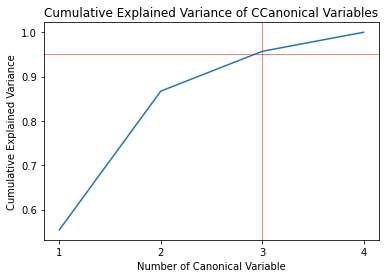

In [247]:
ax = figure().gca()
ax.plot(range(1, len(lda.explained_variance_ratio_) + 1), np.cumsum(lda.explained_variance_ratio_))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel('Number of Canonical Variable')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance of CCanonical Variables')

plt.axvline(x=3, linewidth=1, color='r', alpha=0.5)
plt.axhline(y=0.95, linewidth=1, color='r', alpha=0.5)
show()

In [248]:
X_train_minmaxscaled_reduced = lda.transform(X_train_minmaxscaled)

In [249]:
X_train_minmaxscaled_reduced = X_train_minmaxscaled_reduced[:,:nr_canonical_variables]

In [250]:
X_train_minmaxscaled_reduced = pd.DataFrame(
    X_train_minmaxscaled_reduced,
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

In [251]:
X_val_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_val_minmaxscaled)[:,:nr_canonical_variables],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])
X_test_minmaxscaled_reduced = pd.DataFrame(
    lda.transform(X_test_minmaxscaled)[:,:nr_canonical_variables],
    columns = [f"LD{i}" for i in range(1, X_train_minmaxscaled_reduced.shape[1] + 1)])

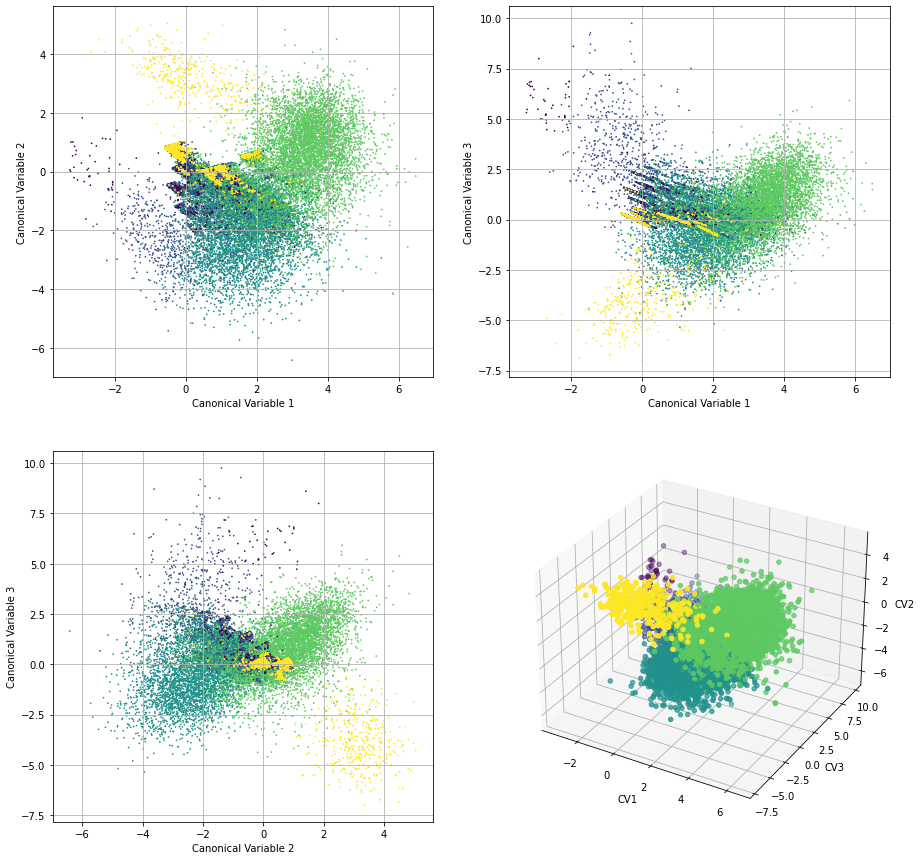

In [252]:
def myplot(n_cv1, n_cv2):
    cv1 = f"LD{n_cv1}"
    cv2 = f"LD{n_cv2}"
    cv1 = X_train_minmaxscaled_reduced[cv1]
    cv2 = X_train_minmaxscaled_reduced[cv2]

    plt.scatter(cv1 ,cv2, c = y_train_categorical, s = 0.5)

    plt.xlabel(f"Canonical Variable {n_cv1}")
    plt.ylabel(f"Canonical Variable {n_cv2}")
    plt.grid()

fig = plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
myplot(1, 2) 

plt.subplot(2, 2, 2)
myplot(1, 3) 

plt.subplot(2, 2, 3)
myplot(2, 3) 

ax = fig.add_subplot(2, 2, 4, projection='3d')
zdata = X_train_minmaxscaled_reduced.LD2
ydata = X_train_minmaxscaled_reduced.LD3
xdata = X_train_minmaxscaled_reduced.LD1
ax.set_xlabel('CV1')
ax.set_ylabel('CV3')
ax.set_zlabel('CV2')
ax.scatter3D(xdata, ydata, zdata, c=y_train_categorical);


In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=X_train_minmaxscaled_reduced.LD1,
    y=X_train_minmaxscaled_reduced.LD3,
    z=X_train_minmaxscaled_reduced.LD2,
    mode='markers',
    marker=dict(
        size=2,
        color=y_train_categorical,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )  
)])

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene = dict(
                    xaxis_title='CV1',
                    yaxis_title='CV3',
                    zaxis_title='CV2'))
fig.show()

In [254]:
X_train_minmaxscaled.columns

Index(['year', 'title_length', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama',
       ...
       'world politics', 'world war i', 'world war ii', 'writer's life',
       'writers', 'writing', 'wuxia', 'wwii', 'zombie', 'zombies'],
      dtype='object', length=1149)

In [255]:
# X_train_minmaxscaled_reduced_to_be_saved = X_train_minmaxscaled_reduced.copy()
# X_val_minmaxscaled_reduced_to_be_saved = X_val_minmaxscaled_reduced.copy()
# X_test_minmaxscaled_reduced_to_be_saved = X_test_minmaxscaled_reduced.copy()
# 
# X_train_minmaxscaled_reduced_to_be_saved['y'] = y_train_categorical.values
# X_val_minmaxscaled_reduced_to_be_saved['y'] = y_val_categorical.values
# X_test_minmaxscaled_reduced_to_be_saved['y'] = y_test_categorical.values
# 
# df_reduced_script = X_train_minmaxscaled_reduced_to_be_saved.append(X_val_minmaxscaled_reduced_to_be_saved).append(X_test_minmaxscaled_reduced_to_be_saved)
# df_reduced_script.to_csv(os.path.join("script_slurm", "df_reduced_RBF.csv"), index=False)

# DATA MODELING

## SVM

### balancing dataset

In [256]:
min_bin_cardinality = df_train.bin_y.value_counts().min()
size = 2000
df_train_SMOTE = balancing(df_train, size)
df_trains = RandomSubSets(df_train_SMOTE, size, n_samples=7) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000

### tuning hyperparameters

set hyperparameters

In [257]:
size_C_range = 2
size_gamma_range = 2
nr_configurations = size_gamma_range*size_C_range

C_range = np.logspace(-2, 5, size_C_range)
gamma_range = np.logspace(-5, 2, size_gamma_range)

##### non usare

In [258]:
# NON USARE EVENTUALE SVILUPPI FUTURI

results = pd.DataFrame(columns=['C', 'gamma', 'loss_ensemble'])
config = 0

X_trains_preprocessed = []
X_vals_preprocessed = []
X_tests_preprocessed = []

for n in range(len(df_trains)):
	print(f"****PRE-PROCESSING su {n+1}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train_SVC, y_train_SVC, weights = split_XYweights(df_trains[n])
	X_val_SVC, y_val_SVC, _ = split_XYweights(df_val)
	X_test_SVC, y_test_SVC, _ = split_XYweights(df_test)

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train_SVC, X_val_SVC, X_test_SVC = MinMaxScaling(X_train_SVC, X_val_SVC, X_test_SVC, ['title_length','year'])

	print("PRE-PROCESSING --> LDA")
	X_train_SVC, X_val_SVC, X_test_SVC = LDA(X_train_SVC, X_val_SVC, X_test_SVC, y_train_SVC)

	X_trains_preprocessed.append(X_train_SVC)
	X_vals_preprocessed.append(X_val_SVC)
	X_tests_preprocessed.append(X_test_SVC)


for c in C_range:
	for gamma in gamma_range:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> C: {c}, gamma: {gamma}")

		print("***********STARTING BAGGING***********")
		for n in range(len(X_trains_preprocessed)):
			print(f"****{n+1}° FIT su {n+1}° sample del train****")

			print("FITTING & PREDICTING")
			svc = svm.SVC(kernel="rbf", C=c, gamma=gamma)
			svc.fit(X_train_SVC, y_train_SVC)

			y_val_pred = svc.predict(X_val_SVC).tolist()
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val_SVC, y_val_pred)
			print(f"LOSS --> {error}")

		print("***********ENDING BAGGING***********")
		
		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val_SVC, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")
        
		results = results.append({
			'C': c,
			'gamma': gamma,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

****PRE-PROCESSING su 1° sample del train****
PRE-PROCESSING --> split_XYweights
PRE-PROCESSING --> MinMaxScaling
PRE-PROCESSING --> LDA
****PRE-PROCESSING su 2° sample del train****
PRE-PROCESSING --> split_XYweights
PRE-PROCESSING --> MinMaxScaling
PRE-PROCESSING --> LDA


KeyboardInterrupt: 

In [ ]:
# df_train.to_csv(os.path.join("script_slurm", "df_train.csv"), index=False)
# df_test.to_csv(os.path.join("script_slurm", "df_test.csv"), index=False)
# df_val.to_csv(os.path.join("script_slurm", "df_val.csv"), index=False)

### RBF kernel

##### tuning hyperparameters

In [ ]:
results = pd.DataFrame(columns=['C', 'gamma', 'loss_ensemble'])
config = 0

for c in C_range:
	for gamma in gamma_range:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> C: {c}, gamma: {gamma}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

			print("PRE-PROCESSING --> split_XYweights")
			X_train, y_train, weights = split_XYweights(df_trains[n])
			X_val, y_val, _ = split_XYweights(df_val)
			X_test, y_test, _ = split_XYweights(df_test)

			print("PRE-PROCESSING --> MinMaxScaling")
			X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

			print("PRE-PROCESSING --> LDA")
			X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

			print("FITTING & PREDICTING")
			svc = svm.SVC(kernel="rbf", C=c, gamma=gamma)
			svc.fit(X_train, y_train)

			y_val_pred = svc.predict(X_val).tolist()
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val, y_val_pred)
			print(f"LOSS --> {error}")

		print("***********ENDING BAGGING***********")

		# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
		# therefore, len(y_val_preds) == len(df_trains)
		# 			 len(y_val_preds[idx]) == len(X_val_SVC) == nr different predictions, with idx the n-th sample
		
		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")
        
		results = results.append({
			'C': c,
			'gamma': gamma,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

##### test with best hyperparameters

In [ ]:
c = 1
gamma = 1

In [ ]:
y_test_preds = []

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train, y_train, weights = split_XYweights(df_trains[n])
	X_val, y_val, _ = split_XYweights(df_val)
	X_test, y_test, _ = split_XYweights(df_test)

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

	print("PRE-PROCESSING --> LDA")
	X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

	print("FITTING & PREDICTING")
	svc = svm.SVC(kernel="rbf", C=c, gamma=gamma)
	svc.fit(X_train, y_train)

	y_test_pred = svc.predict(X_test).tolist()
	y_test_preds.append(y_test_pred)

	error = zero_one_loss(y_test, y_test_pred)
	print(f"LOSS --> {error}")

print("***********ENDING BAGGING***********")

# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
# therefore, len(y_val_preds) == len(df_trains)
# 			 len(y_val_preds[idx]) == len(X_val_SVC) == nr different predictions, with idx the n-th sample

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")

### Polinomial kernel

### Sigmoid kernel

### Custom kernel

#### Feature Engineering

Nella teoria dell'informazione, la distanza di Hamming tra due stringhe di ugual lunghezza è il numero di posizioni nelle quali i simboli corrispondenti sono diversi. 

We want to measure distances between samples by separately considering tags and genres: by the way, we have created two new columns:
- `genres` which collapses in a list the values corresponding to genres' columns;
- `tags` which collapses in a list the values corresponding to tags' columns.

In [ ]:
def distance(a,b):
	d = np.sqrt(np.square(np.subtract(a[0:2], b[0:2])).sum())     # distanze element wise tra year, title_length
	d += np.bitwise_xor(a[2], b[2]).sum()/len(a[2]) # hamming
	d += np.sqrt(np.square(np.subtract(a[3], b[3])).sum())
	return d

#### tuning hyperparameters

In [ ]:
results = pd.DataFrame(columns=['C', 'gamma', 'loss_ensemble'])
config = 0

for c in C_range:
	for gamma in gamma_range:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> C: {c}, gamma: {gamma}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {n+1}° sample del train****")

			print("PRE-PROCESSING --> split_XYweights")
			X_train_split, y_train_SVC, weights = split_XYweights(df_trains[n])
			X_val_split, y_val_SVC, _ = split_XYweights(df_val)
			X_test_split, y_test_SVC, _ = split_XYweights(df_test)

			print("CHANGING DATAFRAME FOR HAMMING")
			X_train = X_train_split.loc[:,["year", "title_length"]]
			X_train['genres'] = X_train_split.iloc[:,2:21].values.tolist()
			X_train['tags'] = X_train_split.iloc[:,22:].values.tolist()

			X_val = X_val_split.loc[:,["year", "title_length"]]
			X_val['genres'] = X_val_split.iloc[:,2:21].values.tolist()
			X_val['tags'] = X_val_split.iloc[:,22:].values.tolist()

			X_test = X_test_split.loc[:,["year", "title_length"]]
			X_test['genres'] = X_test_split.iloc[:,2:21].values.tolist()
			X_test['tags'] = X_test_split.iloc[:,22:].values.tolist()

			print("PRE-PROCESSING --> MinMaxScaling")
			X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ["year", "title_length"])

			print("FITTING & PREDICTING")
			train_distances = cdist(X_train.values, X_train.values, lambda a,b: distance(a,b))
			svc = svm.SVC(kernel="precomputed", C=c, gamma=gamma)
			svc.fit(train_distances, y_train)

			val_distances = cdist(X_val.values, X_train.values, lambda a,b: distance(a,b))
			y_val_pred = svc.predict(val_distances).tolist()
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val, y_val_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
		# therefore, len(y_val_preds) == len(df_trains)
		# 			 len(y_val_preds[idx]) == len(X_val_SVC) == nr different predictions, with idx the n-th sample
		
		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")
        
		results = results.append({
			'C': c,
			'gamma': gamma,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

#### test with best hyperparameters

In [ ]:
c = 1
gamma = 1

In [ ]:
y_test_preds = []

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {n+1}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train_split, y_train_SVC, weights = split_XYweights(df_trains[n])
	X_val_split, y_val_SVC, _ = split_XYweights(df_val)
	X_test_split, y_test_SVC, _ = split_XYweights(df_test)

	print("CHANGING DATAFRAME FOR HAMMING")
	X_train = X_train_split.loc[:,["year", "title_length"]]
	X_train['genres'] = X_train_split.iloc[:,2:21].values.tolist()
	X_train['tags'] = X_train_split.iloc[:,22:].values.tolist()

	X_val = X_val_split.loc[:,["year", "title_length"]]
	X_val['genres'] = X_val_split.iloc[:,2:21].values.tolist()
	X_val['tags'] = X_val_split.iloc[:,22:].values.tolist()

	X_test = X_test_split.loc[:,["year", "title_length"]]
	X_test['genres'] = X_test_split.iloc[:,2:21].values.tolist()
	X_test['tags'] = X_test_split.iloc[:,22:].values.tolist()

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ["year", "title_length"])

	print("FITTING & PREDICTING")
	train_distances = cdist(X_train.values, X_train.values, lambda a,b: distance(a,b))
	svc = svm.SVC(kernel="precomputed", C=c, gamma=gamma)
	svc.fit(train_distances, y_train)

	test_distances = cdist(X_test.values, X_train.values, lambda a,b: distance(a,b))
	y_test_pred = svc.predict(test_distances).tolist()
	y_test_preds.append(y_test_pred)

	error = zero_one_loss(y_test, y_test_pred)
	print(f"LOSS --> {error}")
print("***********ENDING BAGGING***********")

# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
# therefore, len(y_val_preds) == len(df_trains)
# 			 len(y_val_preds[idx]) == len(X_val_SVC) == nr different predictions, with idx the n-th sample

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (C: {c}, gamma: {gamma}) --> {loss_ensemble}\n\n")

***********STARTING BAGGING***********
****1° FIT su 1° sample del train****
PRE-PROCESSING --> split_XYweights
CHANGING DATAFRAME FOR HAMMING


In [ ]:
X_train_SVC = X_train_minmaxscaled.loc[:,["year", "title_length"]]
X_train_SVC['genres'] = X_train_minmaxscaled.iloc[:,2:21].values.tolist()
X_train_SVC['tags'] = X_train_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_train_SVC = X_train_SVC.copy()
# df_train_SVC['bin_y'] = y_train_categorical

X_test_SVC = X_test_minmaxscaled.loc[:,["year", "title_length"]]
X_test_SVC['genres'] = X_test_minmaxscaled.iloc[:,2:21].values.tolist()
X_test_SVC['tags'] = X_test_minmaxscaled.iloc[:,22:-1].values.tolist()
# df_test_SVC = X_test_SVC.copy()

In [ ]:
train_distances = cdist(X_train_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))
svc = svm.SVC(kernel="precomputed", C=1000)
svc.fit(train_distances, y_train_categorical)

In [ ]:
test_distances = cdist(X_test_SVC.values, X_train_SVC.values, lambda a,b: distance(a,b))
y_test_pred = svc.predict(test_distances)

In [ ]:
print(zero_one_loss(y_test_categorical, y_test_pred))

0.99


## Naive Bayes

In [ ]:
for i in range(9):
	size = df_train.bin_y.value_counts().max() / (i+1)
	print(int(size))

In [714]:
size = 2632
n_sample = int(df_train.bin_y.value_counts().max()/size)
print(f"n_sample: {n_sample}")

n_sample: 6


#### tuning hyperparameters

In [790]:
#### tuning hyperparameters
sizes = [5265, 7898, 15797]
min_cats = [5, 10, 300, 500, 1000]
nr_configurations = len(sizes)*len(min_cats)

In [771]:
# make test categorical [1 2 3 4]
df_val_discrete = df_val.copy()
df_val_discrete.iloc[:, 21:-3] = df_val_discrete.iloc[:, 21:-3].apply(lambda x: pd.cut(x, 4, labels=range(4)),axis=1)

In [772]:
df_test_discrete = df_test.copy()
df_test_discrete.iloc[:, 21:-3] = df_test_discrete.iloc[:, 21:-3].apply(lambda x: pd.cut(x, 4, labels=range(4)),axis=1)

In [764]:
df_train_discrete = df_train.copy()
df_train_discrete.iloc[:,21:-3] = df_train_discrete.iloc[:, 21:].apply(lambda x: pd.cut(x, 4, labels=range(4)),axis=1)

In [791]:
results = pd.DataFrame(columns=['size', 'sample', 'min_categories', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train_discrete, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train_discrete.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
		
	for min_cat in min_cats:
		y_val_preds = []
		config += 1
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, min_categories: {min_cat}")

		print("***********STARTING BAGGING***********")
		for n in range(len(df_trains)):
			print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")
			
			print("PRE-PROCESSING --> split_XYweights")
			X_train, y_train, weights = split_XYweights(df_trains[n])
			X_val, y_val, _ = split_XYweights(df_val_discrete)
			X_test, y_test, _ = split_XYweights(df_test_discrete)
			
			print("FITTING & PREDICTING")
			clf = CategoricalNB(min_categories=min_cat)
			clf.fit(X_train, y_train, sample_weight=weights)
			y_val_pred = clf.predict(X_val)
			y_val_preds.append(y_val_pred)

			error = zero_one_loss(y_val, y_val_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		nr_predictions = len(y_val_preds[0])
		y_val_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

		loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
		print(f"LOSS ENSEMBLE (size: {size}, samples: {n_sample}, min_categories: {min_cat}) --> {loss_ensemble}\n\n")

		results = results.append({
			'size': size,
			'sample': n_sample,
			'min_categories': min_cat,
			'loss_ensemble': loss_ensemble
		}, ignore_index=True)

***********BALANCING DATASET***********
************************************** 1 out of 15 params' configurations --> size: 5265, samples: 3, min_categories: 5
***********STARTING BAGGING***********
****1° FIT su 3° sample del train****
PRE-PROCESSING --> split_XYweights
FITTING & PREDICTING
LOSS --> 0.9731425702811245
****2° FIT su 3° sample del train****
PRE-PROCESSING --> split_XYweights
FITTING & PREDICTING
LOSS --> 0.9731425702811245
****3° FIT su 3° sample del train****
PRE-PROCESSING --> split_XYweights
FITTING & PREDICTING
LOSS --> 0.9731425702811245
***********ENDING BAGGING***********
VOTING
LOSS ENSEMBLE (size: 5265, samples: 3, min_categories: 5) --> 0.9731425702811245


************************************** 2 out of 15 params' configurations --> size: 5265, samples: 3, min_categories: 10
***********STARTING BAGGING***********
****1° FIT su 3° sample del train****
PRE-PROCESSING --> split_XYweights
FITTING & PREDICTING
LOSS --> 0.9731425702811245
****2° FIT su 3° sample de

### test

riprendere la conclusione ottenuta in "Evaluating Standardization" per giustificare il fatto che si procede con standardizzazione

execute test

In [ ]:
#X_val.iloc[:, 24:].value_counts(bins=4, sort=False)

##### test with best hyperparameters

In [ ]:
# make test categorical [1 2 3 4]
X_test, y_test, _ = split_XYweights(df_test)
X_test.iloc[:, 21:] = X_test.iloc[:, 21:].apply(lambda x: pd.cut(x, 4, labels=range(4)),axis=1)

In [ ]:
X_train, y_train, w = split_XYweights(df_trains[n])
		X_train.iloc[:, 21:] = X_train.iloc[:, 21:].apply(lambda x: pd.cut(x, 4, labels=range(4)),axis=1)
		X_trains[n] = X_trains[n].append(X_train)
		y_trains[n] = y_trains[n].append(pd.Series(y_train))
		weights[n] = weights[n].append(pd.Series(w))
		
	for min_cat in min_cats:
		print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, min_categories: {min_cats}")
		y_val_preds = []
		config += 1

		print("***********STARTING BAGGING***********")
		for n in range(len(X_trains)):
			print(f"****{n+1}° FIT su {len(X_trains)}° sample del train****")
			print("PRE-PROCESSING --> split_XYweights")
			
			print("FITTING & PREDICTING")
			clf = CategoricalNB(min_categories=min_cat)
			clf.fit(X_trains[n], y_trains[n], sample_weight=weights[n])
			y_test_pred = clf.predict(X_test)
			y_test_preds.append(y_test_pred)

			error = zero_one_loss(y_test, y_test_pred)
			print(f"LOSS --> {error}")
		print("***********ENDING BAGGING***********")

		# y_val_preds = [[predictions after fit su 1° sample], [predictions after fit su 2° sample], [...], ...]
		# therefore, len(y_val_preds) == len(df_trains)
		# 			 len(y_val_preds[idx]) == len(X_val) == nr different predictions, with idx the n-th sample

		nr_predictions = len(y_test_preds[0])
		y_test_pred_voted = []
		print("VOTING")
		for prediction in range(nr_predictions):
			y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])

## Random Forest

### tuning hyperparameters

#### set hyperparameters

In [ ]:
sizes = [1755, 1974, 2256, 2632, 3159, 3949, 5265, 7898, 15797]
n_estimators = [10, 40, 70, 90]
n_criterion = ["gini", "entropy"]
n_bootstrap = [True, False]
class_weight = ["balanced", "balanced_subsample"]
#ccp_alpha # da capire quali sono i valori soliti
#sul fit avrebbe senso valutare con
#sample_weight = ["ratings_count", None]
#weights = X_train.ratings_count
nr_configurations = size_gamma_range*size_C_range

C_range = np.logspace(-2, 5, size_C_range)
gamma_range = np.logspace(-5, 2, size_gamma_range)

#### tuning hyperparameters

In [ ]:
results = pd.DataFrame(columns=['size', 'samples', 'n_estimators', 'criterion', 'bootstrap', 'class_weight', 'loss_ensemble'])
config = 0

for size in sizes:
	print("***********BALANCING DATASET***********")
	df_train_SMOTE = balancing(df_train, size)
	min_size = df_train_SMOTE.bin_y.value_counts().min()
	n_sample = int(df_train.bin_y.value_counts().max()/min_size)
	df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000
	
	for estimator in n_estimators:
		for criterio in n_criterion:
			for boot in n_bootstrap:
				for weight in class_weight:
					y_val_preds = []
					config += 1
					print(f"************************************** {config} out of {nr_configurations} params' configurations --> size: {size}, samples: {n_sample}, n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}")

					print("***********STARTING BAGGING***********")
					for n in range(len(df_trains)):
						print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

						print("PRE-PROCESSING --> split_XYweights")
						X_train, y_train, weights = split_XYweights(df_trains[n])
						X_val, y_val, _ = split_XYweights(df_val)
						X_test, y_test, _ = split_XYweights(df_test)

						print("PRE-PROCESSING --> MinMaxScaling")
						X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

						#print("PRE-PROCESSING --> LDA")
						#X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

						print("FITTING & PREDICTING")
						rf = RandomForestClassifier(n_estimators=estimator, criterion=criterio, bootstrap=boot, class_weight=weight, random_state = 43, n_jobs=-1)
						rf.fit(X_train, y_train)

						y_val_pred = rf.predict(X_val).tolist()
						y_val_preds.append(y_val_pred)

						error = zero_one_loss(y_val, y_val_pred)
						print(f"LOSS --> {error}")
					print("***********ENDING BAGGING***********")

					nr_predictions = len(y_val_preds[0])
					y_val_pred_voted = []
					print("VOTING")
					for prediction in range(nr_predictions):
						y_val_pred_voted.append(Counter([item[prediction] for item in y_val_preds]).most_common(1)[0][0])

					loss_ensemble = zero_one_loss(y_val, y_val_pred_voted)
					print(f"LOSS ENSEMBLE (n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}) --> {loss_ensemble}\n\n")
					
					results = results.append({
						'size': size,
						'samples': n_sample,
						'n_estimators': estimator,
						'criterion': criterio,
						'bootstrap': boot,
						'class_weight': weight,
						'loss_ensemble': loss_ensemble
					}, ignore_index=True)

In [332]:
results.to_csv(os.path.join(current_path, tuning_path,'random_forest.csv'), index=False)  

In [321]:
results

,size,n_estimators,criterion,bootstrap,class_weight,loss_ensemble
0,2000,10,gini,True,balanced,0.603665
1,2000,10,gini,True,balanced_subsample,0.601657
2,2000,10,gini,False,balanced,0.593876
3,2000,10,gini,False,balanced_subsample,0.593876
4,2000,10,entropy,True,balanced,0.605924
5,2000,10,entropy,True,balanced_subsample,0.604418
6,2000,10,entropy,False,balanced,0.601657
7,2000,10,entropy,False,balanced_subsample,0.601657
8,2000,40,gini,True,balanced,0.592118
9,2000,40,gini,True,balanced_subsample,0.589859


In [325]:
results.loc[results['loss_ensemble'] == results['loss_ensemble'].min()]

,size,n_estimators,criterion,bootstrap,class_weight,loss_ensemble
240,9000,70,gini,True,balanced,0.512048
248,9000,90,gini,True,balanced,0.512048


### test with best hyperparameters

In [149]:
estimator = 50
criterio = "gini"
boot = False
weight = "balanced"

df_train_SMOTE = balancing(df_train, size)
n_sample = int(df_train.bin_y.value_counts().max()/size)
min_size = df_train_SMOTE.bin_y.value_counts().min()
df_trains = RandomSubSets(df_train_SMOTE, min_size, n_samples=n_sample) # n_samples a 12 se size == min_bin_cardinality, 7 se == 2000

In [ ]:
y_test_preds = []

print("***********STARTING BAGGING***********")
for n in range(len(df_trains)):
	print(f"****{n+1}° FIT su {len(df_trains)}° sample del train****")

	print("PRE-PROCESSING --> split_XYweights")
	X_train, y_train, weights = split_XYweights(df_trains[n])
	X_val, y_val, _ = split_XYweights(df_val)
	X_test, y_test, _ = split_XYweights(df_test)

	print("PRE-PROCESSING --> MinMaxScaling")
	X_train, X_val, X_test = MinMaxScaling(X_train, X_val, X_test, ['title_length','year'])

	#print("PRE-PROCESSING --> LDA")
	#X_train, X_val, X_test = LDA(X_train, X_val, X_test, y_train)

	print("FITTING & PREDICTING")
	rf = RandomForestClassifier(n_estimators=estimator, criterion=criterio, bootstrap=boot, class_weight=weight, random_state = 43, n_jobs=-1)
	rf.fit(X_train, y_train)

	y_test_pred = rf.predict(X_test).tolist()
	y_test_preds.append(y_test_pred)
	
	error = zero_one_loss(y_test, y_test_pred)
	print(f"LOSS --> {error}")
print("***********ENDING BAGGING***********")

nr_predictions = len(y_test_preds[0])
y_test_pred_voted = []
print("VOTING")
for prediction in range(nr_predictions):
	y_test_pred_voted.append(Counter([item[prediction] for item in y_test_preds]).most_common(1)[0][0])
	
loss_ensemble = zero_one_loss(y_test, y_test_pred_voted)
print(f"LOSS ENSEMBLE (n_estimators: {estimator}, criterion: {criterio}, bootstrap: {boot}, class_weight: {weight}) --> {loss_ensemble}\n\n")

#### Categorical Labels

In [ ]:
sns.barplot(x=rankVar, y=rankVar.index)
plt.xlabel('Variable Importance Score')
plt.ylabel('Variables')
plt.legend()
plt.show()

#### Continuous Labels

In [236]:
rf = RandomForestRegressor(n_estimators=500, random_state = 43, n_jobs=-1)
rf.fit(X_train_RF, y_train_continuous)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test_RF, y_test_continuous))

Avg accuracy:  -0.2692814685064002


In [237]:
rf = RandomForestRegressor(n_estimators=500, random_state = 43, n_jobs=-1, criterion = "poisson")
rf.fit(X_train_RF, y_train_continuous)
# rf.predict(X_test)
print("Avg accuracy: ", rf.score(X_test_RF, y_test_continuous))

In [ ]:
criterion = "poisson" # provare anche "absolute_error" ma attenzione molto più lento
max_features = "log2" # nr di feature da selezionare randomicamente per ogni decision tree
bootstrap = False # If False, the whole dataset is used to build each tree.
# provare parametro weight nella fit, passandogli ratings_count

## Multi Layer Perceptron

# CONCLUSION

# FUTURE WORKS

## Parallel computing in preprocessing

In [ ]:
'''
    alternative code in case .fillna is too computationally intensive
'''

# df.to_csv("df_per_fillna.csv", index=False)
# 
# #os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
# 
# import dask
# import modin.pandas as pd_mod
# df_temp = pd_mod.read_csv("df_per_fillna.csv")
# df_temp.fillna(value=0)
# df_temp.to_csv("df_without_na.csv")
# df = pd.read_csv("df_without_na.csv")

'\n    alternative code in case .fillna is too computationally intensive\n'

## BalancedBaggingClassifier

## RBF bagging voting per maggioranza, in caso di pareggio selezione classe con somma di ratings_count maggiore

# Jovian

In [1]:
import jovian

<IPython.core.display.Javascript object>

In [3]:
jovian.commit(project="project-data-analytics", filename="notebook.ipynb", git_message="2° commit to Jovian", git_commit=True)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "mickperl/project-data-analytics" on https://jovian.ai/
[jovian] Git repository identified. Performing git commit...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/mickperl/project-data-analytics


'https://jovian.ai/mickperl/project-data-analytics'